# Final Project  - Gapfilling Satellite Soil Moisture Time Series using Machine Learning

**Group**: Michael Gradwohl, Maximilian Losbichler, Wolfgang Preimesberger

Note: The latest version of this notebook and the pre-trained models can be downloaded from:

https://github.com/wpreimes/ml_lecture_final_project

In [1]:
import os
import socket
print(socket.gethostname())

macbook.local


In [2]:
import utils as utils
import torch
import torch.nn as nn
torch.manual_seed(123)
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import cartopy.crs as ccrs
from scipy.stats import theilslopes
import ipywidgets as widgets
from statsmodels.tsa.stattools import adfuller
from pytesmo.time_series.anomaly import calc_anomaly, calc_climatology
from pytesmo.interpolate.dctpls import smoothn
import numpy as np
import joblib

reanalysis_reader = utils.ReanalysisReader("extra_era5land_europe/era5land_*.csv")

# Data Selection
The goal of this project is to define a framework to fill observation gaps in satellite measurement time series. We limit our study to a selection of study locations spread across Europe. For each location we have

- The *satellite soil moisture* time series (which naturally contains gaps)
- A *gap-free reanalysis* (observation-enhanced model simulations) time series of soil moisture
- Gap-free time series of reanalysis variables that are **related** to soil moisture (precipitation, evaporation, etc.)
- An *in situ time series* from a measurements station in the satellite grid cell

The following cell will load one data sample (for a selected study `LOCATION`) to use for the rest of the notebook from the available test locations. The time series data will be stored in the global variable `DATA` and the longitude and latitude of the test location as `LON` and `LAT`, respectively.

**Data will be used as selected here when running other cells of this notebook. Use the dropdown list to select a test location and the slider to select a temporal subset.**

In [3]:
@widgets.interact(
    location=widgets.Dropdown(
        options=['Romania', 'Spain1', 'Spain2', 'Austria', 'Germany1', 'Germany2', 'Italy', 'Netherlands', 'France'],
        description='Select location:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px')),
    period=widgets.IntRangeSlider(
        value=[2015, 2020], min=2015, max=2020, step=1, description="Period [year]", 
        layout=widgets.Layout(width='400px'), continuous_update=True)
)
def load_data(location, period):
    global DATA, LAT, LON, LOCATION
    LOCATION = location
    sat, rean, insitu, LAT, LON, other = utils._load_data(location)
    
    print(f"\nLoading data for study site: {location} (Lat={LAT}°, Lon={LON}°)")
    print(f"Period: {period[0]}-01-01 to {period[1]}-12-31\n")
    
    fig = plt.figure(figsize=(12, 5))
    ax_map = plt.axes([0.0, 0.15, 0.4, 0.4], projection=ccrs.PlateCarree())
    utils._marker_on_map(LAT, LON, ax_map, location, other)
    DATA = pd.concat([rean, sat, insitu], axis=1)
    corr = DATA[['satellite SM', 'reanalysis SM', 'in situ SM']].corr()
    DATA.index.name = "Date"
    DATA = DATA.loc[f"{period[0]}-01-01":f"{period[1]}-12-31", :]
    ax = plt.axes([0.45, 0.15, 0.5, 0.4])
    ylabel = 'Vol. SM [m³/m³]'
    ax.set_title(f'Daily mean SM (\'{LOCATION}\' site)', fontsize = 12, loc='left')
    DATA[['satellite SM']].plot(ylabel=ylabel, color='red', label='Satellite', ax=ax, legend=False)
    DATA[['reanalysis SM']].plot(ylabel=ylabel, color='blue', label='ERA5-Land', ax=ax, legend=False)
    DATA[['in situ SM']].plot(ylabel=ylabel, color='green', label='In situ', ax=ax, legend=False)
    ax.text(0.02, 0.02, "$R_{Sat,Rean}$="+f"{corr.iloc[1, 0]:.2f}"+'  '+"$R_{Sat,Insitu}$="+f"{corr.iloc[2, 0]:.2f}", 
        transform=ax.transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    is_gap = DATA['satellite SM'].isna()
    gap_starts = DATA.index[is_gap & ~is_gap.shift(1, fill_value=False)]
    gap_ends   = DATA.index[is_gap & ~is_gap.shift(-1, fill_value=False)]
    for i, (start, end) in enumerate(zip(gap_starts, gap_ends)):
        ax.axvspan(start, end, color='gray', alpha=0.3, linewidth=0, label='Sat. Gap' if i == 0 else None)
    plt.legend(loc="upper right", ncols=2, bbox_to_anchor=(1, 1.3))
    plt.show()
    print("Figure 1 - Study time series selection and comparison of data from different sources")

interactive(children=(Dropdown(description='Select location:', layout=Layout(width='300px'), options=('Romania…

# Explorative Data Analysis

In this chapter we analyse the previously selected time series. 

## Signal decomposition
We look at the 3 main components of a soil moisture signal:
1) The long-term trend is found by fitting a Theil-Sen regression (which is more robust to outliers than a simple least squares regression). This component describes per-year changes in absolute soil moisture levels (e.g. due to climate change).
2) The climatology is found by averaging (and smoothing) data from multiple years (on a day-of-year basis). This component describes climatic (seasonal) cycle for the study location, by removing event-based signals.
3) When removing the trend and the climatology from the signal, short-term variations (anomalies) are left. These are caused by short- to medium-term events (rainfall, droughts, ...).

In the context of gap-filling, an ideal model would consider all signal components, i.e., correctly include trends, seasonal variations and events in the predictions (so that they are consistent with the other observations).

Trend and seasonality can already be estimated well from the available data (Figure 2). Therefore, alternative approach would be to let the ML model predict only the anomalies in the observation gaps, and subsequently restoring a full (gap-free) signal by back-applying the seasonality and trend.

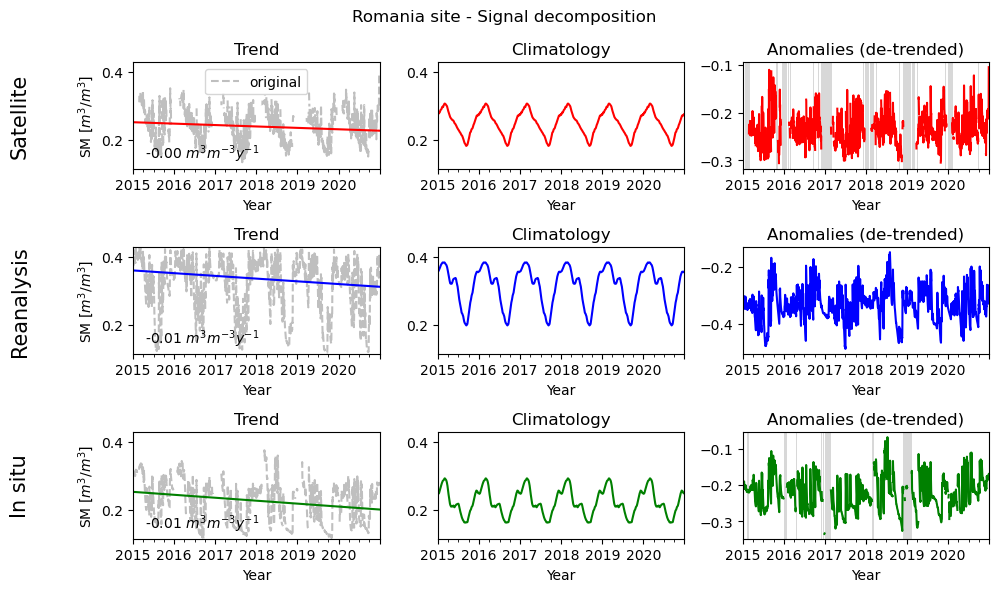

Figure 2 - Soil Moisture signal decomposition (trend, climatology, anomalies) of satellite, reanalyis and in situ time series.


In [4]:
def calc_trend(ts) -> (pd.Series, float, float):
    x, y = ts.index.to_julian_date().values, ts.values
    slope, intercept, _, _ = theilslopes(y, x)  # slope unit = julian date (day)
    trend = pd.Series(index=ts.index, data=slope * x + intercept)
    return trend, slope, intercept


cols = ['satellite SM', 'reanalysis SM', 'in situ SM']
colors = ["red", "blue", "green"]
vrange = (DATA[cols].min().min(), DATA[cols].max().max())

fig, axs = plt.subplots(3, 3, figsize=(10, 6))
row = 0
for col in cols:
    # plot absolute values
    DATA[col].plot(linestyle='--', color='gray', alpha=0.5, ax=axs[row, 0], label='original', 
                   legend=True if row == 0 else False)
    # plot trend
    trend, slope, _ = calc_trend(DATA[col].dropna().copy())
    trend.plot(ax=axs[row, 0], style='-', color=colors[row], xlabel="Year", title='Trend', ylabel="SM [$m^3/m^3$]", ylim=vrange)
    # plot climatology and detrended anomalies
    clim = calc_climatology(DATA[col].copy())
    dat = calc_anomaly(DATA[col].copy(), climatology=clim, return_clim=True)
    axs[row, 0].text(x=0.05, y=0.1, s=f"{slope*365:.2f} "+"$m^3 m^{-3} y^{-1}$", transform=axs[row, 0].transAxes)
    dat['climatology'].plot(ax=axs[row, 1], style='-', color=colors[row], xlabel="Year",
                           title='Climatology', ylim=vrange)
    (dat['anomaly'] - trend).plot(ax=axs[row, 2], style='-', color=colors[row], xlabel="Year",
                       title='Anomalies (de-trended)')
    is_gap = dat['anomaly'].isna()
    gap_starts = dat.index[is_gap & ~is_gap.shift(1, fill_value=False)]
    gap_ends   = dat.index[is_gap & ~is_gap.shift(-1, fill_value=False)]
    for i, (start, end) in enumerate(zip(gap_starts, gap_ends)):
        axs[row, 2].axvspan(start, end, color='gray', alpha=0.3, linewidth=0)
    axs[row, 0].text(s=col.replace(' SM', '').capitalize(), x=-0.5, y=0.5, transform=axs[row, 0].transAxes, 
                     rotation=90, verticalalignment='center', fontsize=15)
    DATA[f"{col} Anomaly"] = dat['anomaly']
    DATA[f"{col} Climatology"] = dat["climatology"]
    DATA[f"{col} Trend"] = trend
    row += 1

plt.suptitle(f"{LOCATION} site - Signal decomposition")
plt.tight_layout()
plt.show()
print("Figure 2 - Soil Moisture signal decomposition (trend, climatology, anomalies) of satellite, reanalyis and in situ time series.")

## Plotting data distributions

We further compare the value distributions of the 3 time series at the selected test location (Figure 3). Some differences are explained by missing data points in the satellite and in situ time series. However, there are still some clear differences between the sources. This is mainly due to differences in the seasonality representation (climatology) as was shown in Figure 2. 

While the original/absolute SM values show a skewed value distribution, the anomalies resemble closer a normal distribution.

In [5]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute Values (full signal)', 'Anomalies'],
        description='Select Data to use:', style={'description_width': '200px'}, layout=widgets.Layout(width='450px'))
)
def compute_dist(comp):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    
    colors = ['red', 'blue', 'green']
    cols = [f'{c} Anomaly' if comp == 'Anomalies' else c for c in ['satellite SM', 'reanalysis SM', 'in situ SM']]
    for i, col in enumerate(cols):
        dat = DATA[col]
        sns.histplot(dat, color=colors[i], kde=True, bins=10, cumulative=False, stat="probability", ax=axs[i])
        axs[i].set_title(col.replace(' SM', '').capitalize())
        text = (f"med={dat.median():.2f}\n" f"std={dat.std():.2f}\n"
                f"min={dat.min():.2f}\n" f"max={dat.max():.2f}")
    
        axs[i].legend([utils._l], [text], loc="best", frameon=True, handlelength=0, handletextpad=0, fontsize=9)

    plt.suptitle(f"{LOCATION} site - Histogram comparison")
    plt.tight_layout()
    plt.show()
    print(f"Figure 3 - Histogram comparison of satellite (left), reanalysis (middle) and in situ (right) data at {LOCATION} site.")

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='450px'), options=('Abso…

## Testing for stationarity

We use the Augmented-Dickey Fuller Test to evaluate whether our data samples are stationary or not. Stationarity means that a time series has constant statistical properties -- mean, variance, and autocorrelation -- over time, which is essential for accurate modeling. 

The ADF test evaluates the hypothesis that a unit root is present in a time series, which indicates a **non-stationary** process. A small enough p-value (below 0.05) and test statistics **more negative than the critical values**, indicate that the null hypothesis can be reliably rejected, and that the time series is stationary. Less negative test statistics indicate non-stationarity.

Generally we find test statistics that are more negative than the critical values -> i.e., stationary. At the same time the p-value is usually <0.05, meaning that we can trust this assessment.

We conclude that soil moisture time series are generally stationary (for the default Romania time series). For the anomaly time series this is even more obvious (test statistics are much lower and p-values are much smaller). 

In [6]:
# Testing for stationarity via Augumented-Dickey Fuller Test
prods = ['satellite SM', 'reanalysis SM', 'in situ SM']
stats = pd.DataFrame(index=['Test statistic', 'p-value'],
                     columns=pd.MultiIndex.from_product([prods, ['Absolute', 'Anomaly']]),
                     data=np.nan)

for i, col in enumerate(stats.columns.values):
    name = ' '.join(col).replace(' Absolute', '')
    res = adfuller(DATA[name].dropna())
    stats.loc['Test statistic', col] = round(res[0], 3)
    # Only if the p-value were to be close to significant, the critical values should be used to judge the hypothesis rejection
    stats.loc['p-value', col] = round(res[1], 5)
    if i == 0:
        for key, value in res[4].items():
            print(f"{key} critical value: {round(value, 3)}")

display(stats)
print(f"\nTable 1 - {LOCATION} ADF stats for absolute SM values and SM anomalies (satellite, reanalysis and in situ)")

1% critical value: -3.435
5% critical value: -2.863
10% critical value: -2.568


satellite SM         reanalysis SM         in situ SM        
                   Absolute Anomaly      Absolute Anomaly   Absolute Anomaly
Test statistic     -3.98200 -13.086      -4.43900   -6.83     -6.564  -9.128
p-value             0.00151   0.000       0.00025    0.00      0.000   0.000


Table 1 - Romania ADF stats for absolute SM values and SM anomalies (satellite, reanalysis and in situ)


## Correlation Analysis

The main task of our ML model is to make predictions of soil moisture in cases where no "direct" observation of SM is possible. However, the model needs to learn about processes that are leading to changes in SM to do this effectively. The ERA5-Land reanalysis provides -- in addition to soil moisture -- other environmental variables, such as precipitation, evaporation, temperature etc.

In a first step we evaluate time series correlations between satellite and reanalysis SM and all available covariates (Figure 4). We find **strong positive correlation** between SM and **evaporation** (more available water leads to more potential evaporation), and strong **negative correlation** with **temperature** (evaporation of SM has a cooling effect).

Somewhat surprisingly, correlation with **precipitation** is quite low. This might, however, be related to the fact that precipitation levels are **discrete** (event-driven/spikes, otherwise zeros) compared to continuous soil moisture changes. Water is stored multiple days to weeks in the soil while dry-down occurs after a precipitation event, leading to lower R-scores when comparing the time series.

This is also confirmed when looking at the correlation scores between anomaly time series. In this case runoff and precipitation show a strong positive correlation with SM, while the correlation with temperature is weaker.

In [7]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute SM Values', 'SM Anomalies'],
        description='Select Data to use:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)
def compute_xcorr(comp):
    global CORR
    col, pearson_sat, pearson_rean = np.array([]), np.array([]), np.array([])
    pfix = ' Anomaly' if comp == 'SM Anomalies' else ''
    for param in DATA.columns:
        if ' SM' in param:
            continue
        dat = DATA[[f"reanalysis SM{pfix}", param]].dropna()  # keep only common obs
        r_rean = scipy.stats.pearsonr(dat[f'reanalysis SM{pfix}'].values, dat[param].values)[0]
        dat = DATA[[f'satellite SM{pfix}', param]].dropna()  # keep only common obs
        r_sat = scipy.stats.pearsonr(dat[f'satellite SM{pfix}'].values, dat[param].values)[0]
        col = np.append(col, param)
        pearson_sat = np.append(pearson_sat, float(r_sat))
        pearson_rean = np.append(pearson_rean, float(r_rean))
    
    order = np.argsort(pearson_rean)
    CORR = pd.DataFrame(index=col[order], data={'Satellite SM': pearson_sat[order], 'Reanalysis SM': pearson_rean[order]})
    
    ax = CORR.plot.barh(xlabel='Correlation [-]', color=["red", "blue"])
    ax.set_title(f"{LOCATION} - Soil Moisture Correlation with Reanalysis variables")
    plt.show()
    print("Figure 4 - Correlation of soil moisture with covariate variables from reanalysis simulations")

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='300px'), options=('Abso…

## Lag analysis

It is logical that there are lags of various lengths in the representation of envents across variables. E.g., strong precipitation will lead to increased runoff and moisture stored in the soil shortly after a rainfall event. As more radiation from the sun leads to evaporation of SM after the event, SM will start to decrease over the coming weeks (dry-down). At the same time, the increased evaporation levels will have a cooling effect on the environment.

We evaluate these temporal relationships between variables as (lagged) correlation functions (Figure 5). We explore temporal cross-correlations between soil moisture and other variables. Short-term (event-based, a few days) and long-term (seasonal, multiple months) patterns are expected, depending on the variables and processes at hand.

In the short term (a few days):
- For events causing changes in soil moisture, POSITIVE lags are expected (e.g. rainfall)
- For events caused by changes in soil moisture, NEGATIVE lags are expected (e.g. evaporation, vegetation decline)


In [8]:
def cross_corr(df, lag=0):
    """Correlation between 2 columns, where one is delayed by n days (lag)"""
    col1, col2 = df.columns
    if col1 == col2:  # Autocorrelation case
        return df.iloc[:, 0].autocorr(lag=lag)
    else:
        return df[col1].corr(df[col2].shift(lag))

@widgets.interact(
    lag_range=widgets.IntRangeSlider(
        value=(-100, 100), min=-366, max=366, step=3, description="Lag [days]", 
        layout=widgets.Layout(width='400px'), continuous_update=False, style={'description_width': '120px'}))
def compute_xcrorr(lag_range):
    lags = np.arange(*lag_range)
    n_rows, n_cols = 5, 4
    params = ["reanalysis SM"] + list(CORR.index.values[::-1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    
    i = 0
    for r in range(n_rows):
        for c in range(n_cols):
            if i >= len(params):
                break
            p = params[i]
            xcorr = [cross_corr(DATA[["reanalysis SM", p]], lag=lag) for lag in lags]
            axs[r, c].axvline(0, color='black', linestyle='--', alpha=0.3)
            axs[r, c].plot(lags, xcorr, linewidth=1, color='orange' if p == "reanalysis SM" else "blue")
            axs[r, c].set_ylim(-1, 1), axs[r, c].set_xlim(*lag_range)
            axs[r, c].set_xlabel("Lag [days]")
            if c == 0:
               axs[r, c].set_ylabel("R [-]")
            axs[r, c].set_title(p[:35] if p != "reanalysis SM" else "Soil Moisture (Autocorrelation)", fontsize=10)
            i += 1

    plt.suptitle(f"{LOCATION} - X-correlations between SM and other reanalysis variables", fontsize=15)
    plt.tight_layout()
    plt.show()
    print("Figure 5 - Lagged (cross) correlations between reanalysis SM and related variables")


interactive(children=(IntRangeSlider(value=(-100, 100), continuous_update=False, description='Lag [days]', lay…

## Gap Analysis

The gap analysis estimates systematics in the distribution of missing values in the satellite time series. There are different underlying causes that lead to missing days in the satellite time series. These can be more or less random (e.g., due to missing satellite overpasses or a failed measurement at a day), but usually are highly systematic. 

The most important factor is, that we cannot measure soil moisture as soon as the water is frozen, as most measurement techniques rely on the sensitivity of liquid water molecules to applying an electromagnetic field. This is however not anymore the case as soon as the water starts to freeze within a scene, leading to very noisy signals during the transition phase from liquid to frozen state, and a drop in the observed quantity when most of the water is frozen.

It strongly depends on the evaluated location (more frozen days in higher latitudes) and the surroundings. Mountains, dense vegetation, cities, all have a confounding effect on the retrievals, often leading to unreliable and therefore masked data points.

### Gap Distribution

First we count the number of gaps in our satellite time series and estimate how large (i.e., consecutively missing days) these gaps are (Figure 6).

Most gaps are short, however, there are long gaps (up to 155 days for the default Romania time series). We expect that larger gaps will be more difficult to fill due to the high temporal autocorrelation level of SM.

Satellite Data Gap Stats:
  Mean gap length:  4.65
  Median gap length:  1.0
  Min gap size:  1
  Max gap size:  81
  N missing:  618
  % missing data points:  28


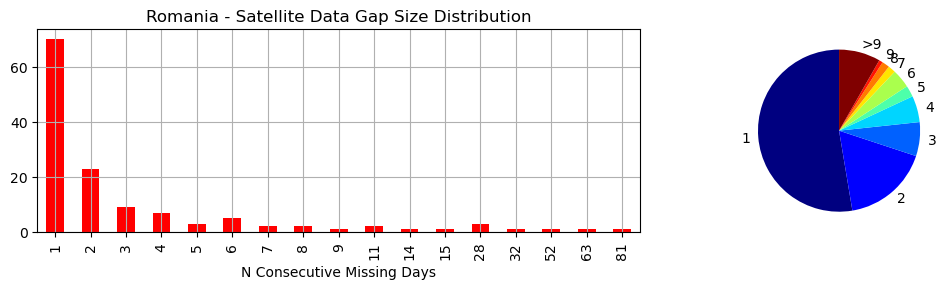

Figure 6 - Gap count in the Romania time series


In [9]:
def count_gaps(arr, dates):
    arr = np.asarray(arr)
    # Find indices where value changes
    diff = np.diff(np.r_[0, arr, 0])

    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    startdates =  dates[starts]

    return pd.DataFrame(index=startdates, 
                        data={'gapsize': (ends - starts).tolist()})


gaps_df = count_gaps(np.isnan(DATA['satellite SM'].values), DATA['satellite SM'].index.values)

uniq = np.unique_counts(gaps_df['gapsize'])
gap_counts = pd.Series(uniq.counts, uniq.values)

print("Satellite Data Gap Stats:")
print('  Mean gap length: ', round(np.mean(gaps_df.values), 2))
print('  Median gap length: ', np.median(gaps_df.values))
print('  Min gap size: ', np.min(gaps_df.values))
print('  Max gap size: ', np.max(gaps_df.values))
print('  N missing: ', np.sum(gaps_df.values))
print('  % missing data points: ', int(len(DATA[DATA['satellite SM'].isna()].index) / len(DATA.index)*100))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3), width_ratios=[0.5, 0.4])

gap_counts.plot.bar( ax=ax1, title=f"{LOCATION} - Satellite Data Gap Size Distribution", 
                  xlabel='N Consecutive Missing Days',
                  grid=True, color='red')

gap_counts_plot = gap_counts.copy()
gap_counts_plot.index = gap_counts_plot.index.astype(str)

above9 = gap_counts[gap_counts.index > 9].sum()
gap_counts_plot = gap_counts[gap_counts.index <= 9].copy()
gap_counts_plot.index = gap_counts_plot.index.astype(str)
gap_counts_plot['>9'] = above9

gap_counts_plot.plot.pie(cmap=plt.get_cmap('jet'), ax=ax2, startangle=90)
fig.tight_layout()
plt.show()
print(f"Figure 6 - Gap count in the {LOCATION} time series")

The previously discussed fact -- that most gaps appear in winter due to frozen soils -- is also evident from Figure 7. It also shows that the longer gaps are the ones due to frozen soils (which persists for multiple months or weeks), while the individual missing days appear (also) in summer.

Earlier periods in the time series are more likely to contain gaps than later ones. This is due to the number of available satellites (the product combines data from 19 satellites), which increased over the last years.

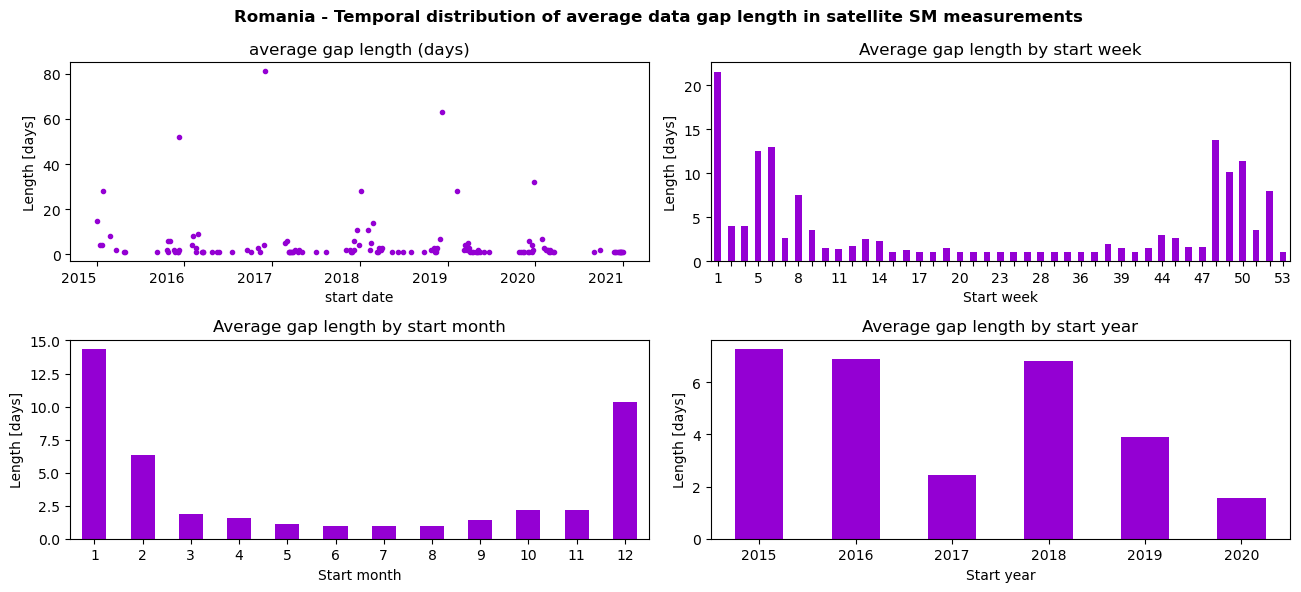

Figure 7 - Temporal gap distribution and gap length


In [10]:
gaps_df['month'] = gaps_df.index.month
gaps_df['weekofyear'] = gaps_df.index.isocalendar().week
gaps_df['year'] = gaps_df.index.year

fig, axs = plt.subplots(2, 2, figsize = (13, 6))
data_gap_dates, data_gap_list = gaps_df.index.values, gaps_df.values
gaps_df['gapsize'].plot(color='darkviolet', title='average gap length (days)', rot=0,
                        marker='.', linewidth=0, ax=axs[0, 0], ylabel='Length [days]', xlabel='start date',
                       )
avg_gapsize_week = gaps_df.groupby('weekofyear').mean()['gapsize']
avg_gapsize_week.plot.bar(
    ax=axs[0, 1], ylabel='Length [days]', xlabel='Start week', color='darkviolet', 
    rot=0, title='Average gap length by start week')
for i, label in enumerate(axs[0, 1].get_xticklabels()):
    if i % 3 != 0:
        label.set_visible(False)
avg_gapsize_month = gaps_df.groupby('month').mean()['gapsize']
avg_gapsize_month.plot.bar(
    ax=axs[1, 0], ylabel='Length [days]', xlabel='Start month', color='darkviolet', 
    rot=0, title='Average gap length by start month')
avg_gapsize_year = gaps_df.groupby('year').mean()['gapsize']
avg_gapsize_year.plot.bar(
    ax=axs[1, 1], ylabel='Length [days]', xlabel='Start year', color='darkviolet', 
    rot=0, title='Average gap length by start year')

fig.suptitle(f'{LOCATION} - Temporal distribution of average data gap length in satellite SM measurements', weight = 'bold')
plt.tight_layout()
plt.show()

print("Figure 7 - Temporal gap distribution and gap length")


## Gap simulation

We will use the gap-free reanalysis data to train our ML model. However, in order to tune it to make predictions for data gaps, we have to introduce realistic gaps to the SM time series first.

In the following cell, we present 4 methods to do this
1) **Random** - Introducing random gaps (30% or 50%) - While this is very easy, it mean that the gap distribution is not representative of the true conditions (as discussed in the previous chapter). We will be left with many, individual, small gaps, which are generally easy to fill.
2) **Forecast** - Removes data at the end of the time series. This simulates the case where we could use our model to make predictions of future SM states (before a satellite measurement is taken). However, it's also not representative of the gap conditions we have in the real data. Classic case for LSTM predictions.
3) **Satellite gaps (original)** - This transfers the true satellite gaps from our test location to all reanalysis data. While this means that we apply realistic gaps, the masks will be the same when applied to a large number of time series (for training). This could lead to overfitting as the model will be trained on one specific gap pattern, while in reality the patterns are much more variable.
4) **Satellite gaps (simulated) / Markov gaps** - This approch (which is the one we ultimately opt for), computes the probability for a gap at each time stamp based on the given satellite time series using Markov transition matrices for each month. For each day, it decides whether a new gap should be started, an existing gap should be continued, or no gap should be introduced. While this will still lead to a gap pattern that depends largely on the base satellite time series, it will introduced some variability in how the data are removed.

The so-removed data points will later be used to assess the quality of our predictions.

**For the rest of the notebook we will use the Markov strategy!**

In [11]:
def markov_gaps(reference: pd.Series) -> pd.Series:
    transitions = {}
    reference.name = 'sm'
    dat = pd.DataFrame(reference)
    dat['sm_available'] = (~np.isnan(dat['sm'])).astype(int)
    dat['month_of_year'] = dat.index.month
    for month, group in dat.groupby('month_of_year'):
        x = group['sm_available'].values
        P00 = ((x[:-1]==0) & (x[1:]==0)).sum() / (x[:-1]==0).sum()
        P01 = 1 - P00
        P11 = ((x[:-1]==1) & (x[1:]==1)).sum() / (x[:-1]==1).sum()
        P10 = 1 - P11
        transitions[month] = [[P00, P01],[P10,P11]]
    
    # ** Simulate gaps 
    states = []
    current_state = 0 # Initial state
    for month_of_day in dat["month_of_year"]:
        # Get current state from previous state by random sampling according to the transition matrix
        current_state = np.random.choice([0, 1], p=transitions[month_of_day][current_state])
        states.append(current_state)
        
    dat["gaps"] = states

    return ~dat['gaps'].astype(bool)


@widgets.interact(
    strategy=widgets.Dropdown(
        options=['Markov Satellite-like (simulated)', 'Satellite gaps (original)', 
                 '30% random', '50% random', '10% forecast'],
        description='Select Gap Strategy:', style={'description_width': '140px'}, layout=widgets.Layout(width='500px')),
)
def train_test_split(strategy):
    global PREDICTION
    PREDICTION = pd.DataFrame(data={'original': DATA['reanalysis SM'].copy()})

    if strategy == 'Satellite gaps (original)':
        PREDICTION['gaps'] = np.isnan(DATA['satellite SM'])
    elif strategy == 'Markov Satellite-like (simulated)':
        PREDICTION['gaps'] = markov_gaps(DATA['satellite SM'])
    elif strategy.endswith("random"):
        percent_random = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        rand_idx = sorted(np.random.choice(list(range(len(PREDICTION.index))), 
                                           size=int(len(PREDICTION.index) * (percent_random / 100)), replace=False))
        PREDICTION.iloc[rand_idx, 1] = True
    elif strategy.endswith("forecast"):
        precent = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        N = int(len(PREDICTION.index) * (precent / 100))
        PREDICTION.iloc[slice(-N, None), 1] = True
    else:
        raise NotImplementedError()

    #Select which gap type to use
    PREDICTION['test'] = PREDICTION.loc[PREDICTION['gaps'] == True, 'original']
    PREDICTION['train'] = PREDICTION.loc[PREDICTION['gaps'] == False, 'original']

    print(f"N train = {len(PREDICTION.train.dropna())}, N test = {len(PREDICTION.test.dropna())}")

    PREDICTION[['test', 'train']].plot(figsize=(8, 3), title=f"{LOCATION} - Reanalysis SM Train/Test split", 
                                       ylabel="SM $[m^3m^{-3}]$")
    plt.show()
    print("Figure 8 - Train test split. 'test' indicates the artificially introduced gaps we aim to restore.")

interactive(children=(Dropdown(description='Select Gap Strategy:', layout=Layout(width='500px'), options=('Mar…

# Baseline Predictions

We apply 3 baseline models to fill the previously introduced gaps and compare against our ML predictions (Figure 9):

1) **Forward Filling** - Repeating the last value before a gap to fill missing points over time with constant values.
2) **Linear Interpolation** - Simulating a linear change over time based on the data point before/after a gap
3) **DCT-PLS (cosine transform fit)** - 2d optimal smoother (here applied without spatial neighbourhood information) based on a fit of a combination of cosine function to the available data points, therefore interpolating any gaps. Our implentation is taken from the [pytesmo package](https://github.com/TUW-GEO/pytesmo) (by TU Wien).

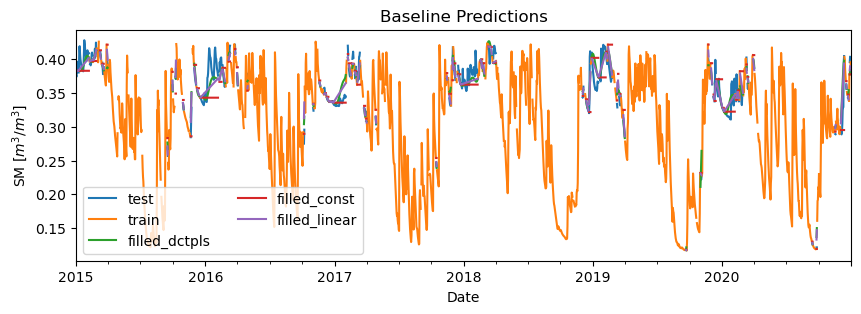

Figure 9 - Comparison of baseline predictions against 'test' values


In [12]:
PREDICTION['filled_dctpls'] = smoothn(PREDICTION['train'].values.copy(), isrobust=True)[0]
PREDICTION['filled_const'] = PREDICTION['train'].ffill().bfill()
PREDICTION['filled_linear'] = PREDICTION['train'].interpolate('linear', limit_direction='both')

for col in PREDICTION.columns:  # Only keep new values
    if col.startswith('filled_'):
        PREDICTION.loc[~PREDICTION['gaps'], col] = np.nan
        
PREDICTION.drop(columns='original').plot(figsize=(10, 3), title='Baseline Predictions', ylabel="SM [$m^3/m^3$]")
plt.legend(ncols=2)
plt.show()
print("Figure 9 - Comparison of baseline predictions against 'test' values")

# LSTM Training

We use the ERA5-Land reanalysis data from up to 1000 locations across Europe for training (the sample size can be chosen freely, larger samples should lead to a better model). We don't use any data at the test location for training! The model parameters after training will be stored for future use (as training with large data samples can take quite long).

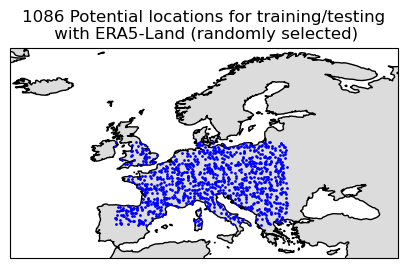

Figure 10 - Location of randomly extracted ERA5-Land time series (all variables) 
 that can be used for training the model


In [13]:
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.add_feature(cfeature.LAND, facecolor="gainsboro")
ax.add_feature(cfeature.COASTLINE, linewidth=1)
lons, lats = reanalysis_reader.lons, reanalysis_reader.lats

for (_lon, _lat) in zip(lons, lats):
        ax.plot(
        _lon, _lat,
        marker="o",
        color="black",
        markersize=1,
        markeredgecolor="blue",
        transform=ccrs.PlateCarree(),
    )
_ = ax.set_title(f"{len(lons)} Potential locations for training/testing\n with ERA5-Land (randomly selected)")
plt.show()
print("Figure 10 - Location of randomly extracted ERA5-Land time series (all variables) \n that can be used for training the model")

## LSTM Model Definition

SM predictions for a day depend strongly on recent precipitation, evaporation, and the moisture state of previous days. LSTMs are particularly well suited for this task because their gated memory mechanism allows them to selectively retain relevant information over long time spans, **capturing both short-term responses to rainfall events and slower multi-week drying trends**. Unlike simple interpolation methods, an **LSTM can integrate multiple climate drivers** (precipitation, temperature, potential evaporation) alongside the temporal context of the SM signal itself, learning the complex nonlinear relationship between atmospheric forcing and soil moisture dynamics. 

We use a **bidirectional architecture** as it allows the model to base predictions on observations from both before and after a gap, using the full available temporal context rather than only past values.

The model consists of the following layers:
1) **Bi-LSTM Layer 1** : captures short-term feature interactions, output is 2*hidden_size dimensional
2) **Dropout**: standard dropout between the two LSTM layers
3) **Bi-LSTM Layer 2**: captures long-term trends from layer-1 hidden states
4) **Time-Distributed Dense (fc)**: maps each time-step hidden state to a scalar, applied identically across all time steps
5) **Output activation:** y = 0.1 + 0.9 * sigmoid(out) → constrains predictions to [0.1, 1.0] (soil moisture range)

In [14]:
class BiLSTMModel(nn.Module):
    def __init__(self, n_features: int, hidden_size: int = 64, dropout: float = 0.2):
        super().__init__()
        self.bilstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(p=dropout)
        self.bilstm2 = nn.LSTM(
            input_size=2 * hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(2 * hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.bilstm1(x)
        out     = self.dropout(out)
        out, _ = self.bilstm2(out)
        logits  = self.fc(out)
        return 0.1 + 0.9 * torch.sigmoid(logits)

## Loss function
Our loss function is a modified version of the MSE. In the current implementation we ignore the gap values (which are set to 0 beforehand) and fit on the available observations instead, minimizing the mean squared differences between predictions and targets, ensuring that the prediction match well to the available observations.

In [15]:
class MaskedMSELoss(nn.Module):
    def forward(self, preds, targets):
        mask_observed = (targets != 0)
        return ((preds[mask_observed] - targets[mask_observed]) ** 2).mean()

The following cell contains some helper function we need
1) **make_windows** - Training and prediction is done on a (moving) window basis (we will use 150 days later). I.e., we don't use the complete time series, but break it up into multiple overlapping windows for training. The `stride` parameter indicates how far these windows are apart (10 days by default). This way we get more data for training, the windows will also have a varying amount of data (as gaps are systematically distributed over time).
2) **TimeSeriesDataset** - Is just a wrapper that turns our input arrays into torch tensors so that they work int he pytorch framework
3) **ReanalysisReader** and **load_location** - Read in the training data. We can give it an integer (from 0 about 1000), and it will read a different reanalysis time series within Europe (from the `extra_era5land_europe` folder). It will also add the simulated Markov (satellite-like) gaps to the data.
4) **encode_gaps** - One of our features is the gap size, as a measure of potential uncertainty (values in larger gaps should be harder to predict). This function just fills gaps with a count of consecutively missing days.
5) **preprocess_columns** - This function adds additional features to a passed time series. It encodes the day of year as a combination of cosine/sine functions. It also log-transforms the precipitation data (to help the model differentiate between no and light rainfall). Finally, it adds a binary gap mask column and the previously discussed gap-size encoder.
6) **run_batches** - Loops through the data and evaluates the data (forward pass, loss function) or applies optimization (if passed -- we use Adam optimizer), which computes predictions, calculates the loss, backpropagates gradients and updates model weights for each batch.

In [16]:
def make_windows(df, features, target, window, stride=10):
    X, y = [], []
    for i in range(window, len(df), stride):
        X.append(df[features].iloc[i - window:i].values)
        y.append(df[target].iloc[i - window:i].values)
    return np.array(X), np.array(y)
    
class TimeSeriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def encode_gaps(s: pd.Series, max_gap: int = 60) -> pd.Series:
    """ Fill gaps with consecutive counts that indicate the uncertainty"""
    is_nan = s.isna().astype(int)
    groups = (is_nan.diff() != 0).cumsum()
    return is_nan.groupby(groups).cumsum().clip(upper=max_gap)

    
def load_location(i_loc, add_markov_gaps_sm=True) -> TimeSeriesDataset:
    """Load, scale, and window a single location. Only this stays in RAM."""
    df = reanalysis_reader.read_fid(i_loc)

    # We add some gaps to the soil moisture data
    if add_markov_gaps_sm:
        gaps = markov_gaps(DATA.loc['2010-01-01':'2020-12-31', 'satellite SM'])
        df.loc[gaps[gaps].index, 'reanalysis SM'] = np.nan
        
    return df

def preprocess_columns(df, columns=None):
    df['doy_sin'] = np.sin(2*np.pi * df.index.dayofyear / 365.25)
    df['doy_cos'] = np.cos(2*np.pi *  df.index.dayofyear / 365.25)
    # apply log transform to precipitation data
    df['Total precipitation'] = np.log(1 + df['Total precipitation'].values)

    # add a separate mask variable
    df['mask'] = np.isnan(df['reanalysis SM'].values).astype(int)
    df['timedelta'] = encode_gaps(df['reanalysis SM'])

    if columns is not None:
        df = df[columns]

    return df


def run_batches(model, loader, criterion, optimizer=None) -> float:
    """
    One pass over a DataLoader.
    optimizer given  →  training pass (gradients computed + applied)
    optimizer=None   →  validation pass (no gradients)
    Returns mean loss over all samples in the loader.
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_samples = 0.0, 0
    ctx = torch.enable_grad() if is_train else torch.no_grad()

    with ctx:
        for xb, yb in loader:
            #xb, yb = xb, yb.to(device)
            if is_train:
                optimizer.zero_grad()
            preds = model(xb)
            loss  = criterion(preds, yb)
            if is_train:
                loss.backward()
                optimizer.step()
            total_loss    += loss.item() * xb.size(0)
            total_samples += xb.size(0)

    return total_loss / total_samples

## Model training

The following cell will run the training loop using data from the selected number of potential training (and testing) locations (Figure 10). More training (and test) locations should lead to a better model, but will take longer for training.

The following hyperparameters are set (changing them requires re-training)

- **window** — the number of consecutive days fed to the LSTM as input for each sample. A window of 150 days gives the model roughly 5 months of temporal context, enough to capture seasonal dynamics and multi-week drying/wetting cycles. Longer windows provide more context but increase memory usage and training time.
- **stride** — the step size in days between consecutive windows extracted from the same time series. A stride of 10 means windows overlap heavily (140 of 150 days are shared between adjacent windows), which increases the number of training samples from a limited time series. A smaller stride generates more samples but with higher redundancy; a larger stride produces fewer, more independent samples.
- **batchsize** — the number of windows processed together in one forward/backward pass. Larger batches give more stable gradient estimates but require more memory; smaller batches introduce more noise into the gradient updates which can sometimes help generalisation. 32 is a standard default.
- **hidden_size** - The number of units in each LSTM direction. Since the architecture is bidirectional, the actual output at each time step is 2 × 64 = 128 dimensional. Larger hidden sizes increase model capacity but also the risk of overfitting, especially with limited training locations.
- **dropout** - the fraction of connections randomly dropped between the two Bi-LSTM layers during training. 20% dropout forces the model to learn redundant representations and reduces overfitting. It is automatically disabled during inference.
- **learn_rate** - Controls how large a step the Adam optimiser takes when updating weights. 0.001 is the standard Adam default and generally a safe starting point for LSTMs.
- **n_epochs** = 100 — the maximum number of full passes over the training data. In practice early stopping will terminate training before this limit is reached if the validation loss stops improving for patience consecutive epochs, so 100 serves as an upper bound rather than a fixed training length.

The following features are used and scaled as part of the pipeline as they were found be highly correlated with SM. Ideally more features would be used:
- Total precipitation (after log-transform)
- Skin temperature
- Potential evaporation
- mask, timedelta, doy_sin, doy_cos

**Note that Soil Moisture itself is NOT a feature in the current setup, which means that our predictions currently depend only on the covariate variables**

In [17]:
# Training params
train_locs = 900   # number of (shuffled) locations used for training (up to 1000)
test_locs = 150

######### DANGER ZONE #######
# Better not change these anymore...
window = 150   # Temporal window length (days) for each location
stride = 10 # Step size (days) between windows
batchsize = 32
hidden_size = 64
dropout = 0.2
learn_rate = 0.001
n_epochs = 100

columns = ['reanalysis SM', 
           'Total precipitation', 'Skin temperature', 'Potential evaporation', 
           'mask', 'timedelta', 'doy_sin', 'doy_cos']

include_sm_as_feature = False

if False:   # safety switch to not start a new training run
    model_name = f"AbsSM_{train_locs}_{test_locs}.pt"
    rng = np.random.default_rng(123)
    
    all_loc_ids = list(range(len(reanalysis_reader.files)))
    rng.shuffle(all_loc_ids)
    
    train_loc_ids = all_loc_ids[:train_locs]
    val_loc_ids = all_loc_ids[train_locs:train_locs+test_locs]
    
    print(f"Train locations: {len(train_loc_ids)}  |  Val locations: {len(val_loc_ids)}")
    
    # ── Model, loss, optimiser ────────────────────────────────────────────────────
    model = BiLSTMModel(n_features=len(columns)-(0 if include_sm_as_feature else 1),
                        hidden_size=hidden_size,
                        dropout=dropout,
                       )
    
    
    criterion = MaskedMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    # Early stopping
    patience = 10
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_state = None
    
    print(f"Starting training a new model from {train_locs} training and {test_locs} test locs")
    # Loading in the data for all training locations at once, gaps are NaN in this case so the scaling works
    train_df = pd.concat([preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) 
                              for loc in train_loc_ids], axis=0)
    
    # Scaling all SM values between 0.1 and 1, nans are 0
    sm_scaler = MinMaxScaler((0.1, 1))
    sm_scaler.fit(train_df['reanalysis SM'].values[..., np.newaxis])
    
    # scaling precipitation from 0 to 1
    precip_scaler = MinMaxScaler((0, 1))
    precip_scaler.fit(train_df['Total precipitation'].values[..., np.newaxis])
    
    # scaling PET as 0 mean 1 std
    pet_scaler = StandardScaler()
    pet_scaler.fit(train_df['Potential evaporation'].values[..., np.newaxis])
    
    # scaling skt as 0 mean 1 std
    skt_scaler = StandardScaler()
    skt_scaler.fit(train_df['Skin temperature'].values[..., np.newaxis])
    
    joblib.dump(sm_scaler, f"model_params/sm_scaler_{train_locs}_{test_locs}.joblib")
    joblib.dump(precip_scaler, f"model_params/precip_scaler_{train_locs}_{test_locs}.joblib")
    joblib.dump(pet_scaler, f"model_params/pet_scaler_{train_locs}_{test_locs}.joblib")
    joblib.dump(skt_scaler, f"model_params/skt_scaler_{train_locs}_{test_locs}.joblib")
    
    del train_df   # discard as we have the scaling params now, load again
    
    # Both contain GAPS in soil moisture -> replaced with 0
    train_dfs = [preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) for loc in train_loc_ids]
    val_dfs = [preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) for loc in val_loc_ids]
    
    def scale_df(df):
        df['reanalysis SM'] = sm_scaler.transform(df['reanalysis SM'].values[..., np.newaxis])
        df['reanalysis SM'] = df['reanalysis SM'].fillna(0)
        df['Total precipitation'] = precip_scaler.transform(df['Total precipitation'].values[..., np.newaxis])
        df['Potential evaporation'] = pet_scaler.transform(df['Potential evaporation'].values[..., np.newaxis])
        df['Skin temperature'] = skt_scaler.transform(df['Skin temperature'].values[..., np.newaxis])
        return df
    
    # ── Window each location separately, then pool ────────────────────────────────
    # Windowing after concat would create windows that bleed across location
    # boundaries, mixing time series from different places
    def make_dataset(dfs):
        X_all, y_all = [], []
        for df in dfs:
            X, y = make_windows(df, 
                                columns if include_sm_as_feature else [c for c in columns if c != "reanalysis SM"], 
                                "reanalysis SM", window, stride)
            X_all.append(X)
            y_all.append(y)
        return TimeSeriesDataset(np.concatenate(X_all), np.concatenate(y_all))
    
    train_dfs = [scale_df(df) for df in train_dfs]
    val_dfs   = [scale_df(df) for df in val_dfs]
    
    train_ds = make_dataset(train_dfs)
    val_ds   = make_dataset(val_dfs)
    
    train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batchsize, shuffle=False)
    
    print(f"Train windows: {len(train_ds)}  |  Val windows: {len(val_ds)}")
    
    # ── Training loop ─────────────────────────────────────────────────────────────
    for epoch in range(n_epochs):
    
        train_loss = run_batches(model, train_loader, criterion, optimizer)
        val_loss   = run_batches(model, val_loader,   criterion)
    
        print(
            f"Epoch [{epoch + 1:3d}/{n_epochs}]  "
            f"Train Loss: {train_loss:.6f}  "
            f"Val Loss: {val_loss:.6f}"
        )
    
        if val_loss < best_val_loss:
            best_val_loss     = val_loss
            best_state        = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
    
    # ── Restore & save ────────────────────────────────────────────────────────────
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nBest val loss: {best_val_loss:.6f}")
    
    torch.save({
        "model_state_dict": model.state_dict(),
        "hyperparams": {
            "n_features": len(columns) if include_sm_as_feature else len(columns) - 1,
            "hidden_size": hidden_size,
            "dropout": dropout,
            "window": window,
            "stride": stride,
            "columns": columns,
            "include_sm_as_feature": include_sm_as_feature,
        },
        "training_info": {
            "train_locs": train_locs,
            "test_locs": test_locs,
            "best_val_loss": best_val_loss,
        }
    }, f"model_params/{model_name}")
                
    print("Training done, model parameters stored for future loading without re-training.")


## Loading a previously trained model

After training, we store our hyperparameters, model state parameters and scaling functions. This way, we can load an existing model later and re-use it to make predictions.

**NOTE: Pre-trained models are not included in this Notebook but available at https://github.com/wpreimes/ml_lecture_final_project/tree/master/model_params** They must be stored in a folder `model_params` next to this notebook.

The next cell will do this if necessary.

In [21]:
# Download the model parameters if they don't exist yet locally
output_dir = os.path.join(os.getcwd(), "model_params")

if os.path.isdir(output_dir) and len(os.listdir(output_dir)) > 0:
    print(f"model_params folder already exists with {len(os.listdir(output_dir))} file(s). Skipping download.")
else:
    print("model_params folder missing or empty. Downloading...")
    utils.download_model_params()

model_params folder already exists with 15 file(s). Skipping download.


In the following cell, we can select a pre-trained model to load and use for the rest of the notebook. Generally it's recommended to use the largest model. The according scalers are also loaded, so that we can back-transform any predictions.

In [19]:
import re

m = None
@widgets.interact(
    mod=widgets.Dropdown(
        options=[f for f in os.listdir('model_params') if f.endswith('.pt')][::-1],
        description='Select existing model (larger=better)', 
        style={'description_width': '300px'}, layout=widgets.Layout(width='600px'))
)
def load_model(mod):
    global model_name
    global checkpoint
    global model, model_name, checkpoint, window, columns, include_sm_as_feature
    model_name = mod
    checkpoint = torch.load(f"model_params/{mod}")

    match = re.search(r"_(\d+)_(\d+)\.pt$", model_name)
    train_locs = int(match.group(1))
    test_locs  = int(match.group(2))
    
    hp = checkpoint["hyperparams"]
    
    # Rebuild model with the exact architecture used during training
    model = BiLSTMModel(
        n_features=hp["n_features"],
        hidden_size=hp["hidden_size"],
        dropout=hp["dropout"],
    )
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    # Restore training config so inference code uses correct values
    window   = hp["window"]
    columns  = hp["columns"]
    include_sm_as_feature = hp["include_sm_as_feature"]

    global sm_scaler
    global precip_scaler
    global pet_scaler
    global skt_scaler
    # restore scalers for the current config
    print(f"Restoring scalers for config {train_locs}_{test_locs}")
    
    sm_scaler = joblib.load(f"model_params/sm_scaler_{train_locs}_{test_locs}.joblib")
    precip_scaler = joblib.load(f"model_params/precip_scaler_{train_locs}_{test_locs}.joblib")
    pet_scaler = joblib.load(f"model_params/pet_scaler_{train_locs}_{test_locs}.joblib")
    skt_scaler = joblib.load(f"model_params/skt_scaler_{train_locs}_{test_locs}.joblib")
    
    print(f"Model {model_name} loaded.")
    print(f"  n_features={hp['n_features']}, hidden_size={hp['hidden_size']}, "
          f"window={hp['window']}, include_sm={hp['include_sm_as_feature']}")
    print(f"  Best val loss during training: {checkpoint['training_info']['best_val_loss']:.6f}")


interactive(children=(Dropdown(description='Select existing model (larger=better)', layout=Layout(width='600px…

Now that we have loaded a model, we can use it to make some predictions.

We load in the features (from the reanalysis data) at our test location, scale them, and feed them to the model on the same window basis as used for training. However, we only make predictions for the time stamps that are missing (gaps).

In [20]:
from tqdm import tqdm
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

print(f"Predicting SM at the {LOCATION} location using the {model_name} model")

def scale_df(df):
    df['reanalysis SM'] = sm_scaler.transform(df['reanalysis SM'].values[..., np.newaxis])
    df['reanalysis SM'] = df['reanalysis SM'].fillna(0)
    df['Total precipitation'] = precip_scaler.transform(df['Total precipitation'].values[..., np.newaxis])
    df['Potential evaporation'] = pet_scaler.transform(df['Potential evaporation'].values[..., np.newaxis])
    df['Skin temperature'] = skt_scaler.transform(df['Skin temperature'].values[..., np.newaxis])
    return df
    
feature_cols = columns if include_sm_as_feature else [c for c in columns if c!= 'reanalysis SM']
dat = DATA.copy()

dat['reanalysis SM'] = PREDICTION['train'].values
dat = scale_df(preprocess_columns(dat, columns=columns))
PREDICTION['filled_lstm_scaled'] = np.nan

model.eval()
with torch.no_grad():
    for i in tqdm(range(window, len(dat.index))):
        x = dat[feature_cols].iloc[i-window:i].values
        x = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)
        y_hat = model(x).squeeze()

        # fill only the gap positions within this window
        for j, abs_idx in enumerate(range(i-window, i)):
            if bool(PREDICTION["gaps"].iloc[abs_idx]) is True:
                PREDICTION.iloc[abs_idx, PREDICTION.columns.get_loc("filled_lstm_scaled")] = y_hat[j].item()

Predicting SM at the Romania location using the AbsSM_900_150.pt model


100%|██████████████████████████████████████| 2042/2042 [00:16<00:00, 126.37it/s]


We back-transform the predictions using the SM scaler, so that the values match with the existing ones (assuming we have no bias in our predictions).

In [22]:
mask = PREDICTION['filled_lstm_scaled'].notna()
PREDICTION['filled_lstm'] = np.nan
PREDICTION.loc[mask, 'filled_lstm'] = sm_scaler.inverse_transform(
    PREDICTION.loc[mask, 'filled_lstm_scaled'].values[..., np.newaxis]
).flatten()
PREDICTION.drop(columns='filled_lstm_scaled', inplace=True)

For a first assessment, we check the correlation between the test samples and our predictions (how close we come to the previously removed values) in Figure 11.

While the correlation is overall not so bad, in the current setup the LSTM is behind the basline models.

,test,filled_dctpls,filled_const,filled_linear,filled_lstm
test,1.000000,0.942302,0.867552,0.947794,0.727540
filled_dctpls,0.942302,1.000000,0.916853,0.991118,0.700704
filled_const,0.867552,0.916853,1.000000,0.932438,0.611449
filled_linear,0.947794,0.991118,0.932438,1.000000,0.712344
filled_lstm,0.727540,0.700704,0.611449,0.712344,1.000000


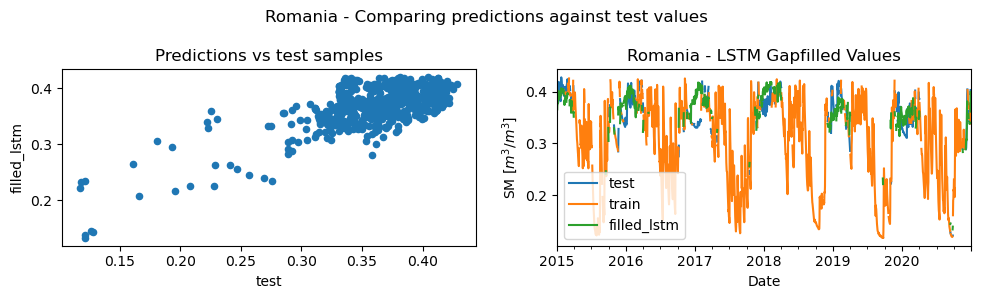

Figure 11 - Comparing LSTM SM predictions in artificial gaps against the true (test) values


In [23]:
corrs = PREDICTION[['test'] + [c for c in PREDICTION.columns if c.startswith('filled')]].corr()

display(corrs)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
PREDICTION[['test', 'filled_lstm']].plot.scatter(0, 1, ax=ax1, title="Predictions vs test samples")
PREDICTION[['test', 'train', 'filled_lstm']].plot(ax=ax2, title=f"{LOCATION} - LSTM Gapfilled Values",
                                                 ylabel='SM $[m^3/m^3]$')
fig.suptitle(f"{LOCATION} - Comparing predictions against test values")
plt.tight_layout()
plt.show()
print("Figure 11 - Comparing LSTM SM predictions in artificial gaps against the true (test) values") 

## Fine-tuning and satellite time series gap-filling
Previously, we used the globally trained (base) model which knows somewhat about the relationship between soil moisture and covariates based on the data for Europe. In order to improve the prediction for a specific location, it could make sense to fine-tune the model for our study site. This will also tune the model somewhat to work for **satellite** gap filling rather than reanalysis gap filling.

We therefore apply a second training run, on top of the pre-trained model, using the **satellite** data from the current study site. We freeze all layers in the model, except the last one (Time-Distributed Dense). We now repeat the training, using the same strategy as before. It's much faster now as we only use the data from a single time series. We therefore can do this on-the-fly (but it might take a bit).

In [24]:
ft_learn_rate  = 1e-4    # much lower than pre-training to avoid forgetting
ft_n_epochs    = 1000
ft_patience    = 5
ft_freeze_lstm = True    # True: only train fc layer; False: finetune everything

if ft_freeze_lstm:
    for name, param in model.named_parameters():
        param.requires_grad = (name.startswith("fc"))  # only train output layer
    print("LSTM layers frozen, finetuning dense head only")
else:
    for param in model.parameters():
        param.requires_grad = True
    print("Finetuning all layers with reduced learning rate")

ft_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=ft_learn_rate
)
ft_criterion = MaskedMSELoss()


ft_df = DATA.copy()
ft_df['reanalysis SM'] = DATA['satellite SM']   # it's actually satellite data now!!!!
ft_df = scale_df(preprocess_columns(ft_df, columns=columns))
ft_feature_cols = [c for c in columns if c != 'reanalysis SM']

ft_X, ft_y = make_windows(ft_df, ft_feature_cols, 'reanalysis SM', window, stride)
ft_ds = TimeSeriesDataset(ft_X, ft_y)

# Train/val split: last 20% of windows as val (temporal split, no shuffling)
n_ft_val   = max(1, int(len(ft_ds) * 0.2))
n_ft_train = len(ft_ds) - n_ft_val

ft_train_ds, ft_val_ds = torch.utils.data.random_split(
    ft_ds, [n_ft_train, n_ft_val],
    generator=torch.Generator().manual_seed(42)
)

ft_train_loader = DataLoader(ft_train_ds, batch_size=batchsize, shuffle=True)
ft_val_loader   = DataLoader(ft_val_ds, batch_size=batchsize, shuffle=False)

print(f"Finetune windows: {n_ft_train} train  |  {n_ft_val} val")

ft_best_val_loss = np.inf
ft_epochs_no_improve = 0
ft_best_state = None

for epoch in range(ft_n_epochs):
    train_loss = run_batches(model, ft_train_loader, ft_criterion, ft_optimizer)
    val_loss   = run_batches(model, ft_val_loader,   ft_criterion)

    if (epoch + 1) % 10 == 0:
        print(
            f"Finetune Epoch [{epoch + 1:3d}/{ft_n_epochs}]  "
            f"Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}"
        )

    if val_loss < ft_best_val_loss:
        ft_best_val_loss     = val_loss
        ft_best_state        = {k: v.clone() for k, v in model.state_dict().items()}
        ft_epochs_no_improve = 0
    else:
        ft_epochs_no_improve += 1
        if ft_epochs_no_improve >= ft_patience:
            print(f"Early stopping at finetune epoch {epoch + 1}")
            break

# ── Restore best finetuned weights ───────────────────────────────────────────
if ft_best_state is not None:
    model.load_state_dict(ft_best_state)
    print(f"\nBest finetune val loss: {ft_best_val_loss:.6f}")

model.eval()
print("Finetuning done — re-run inference cell to get updated predictions")

LSTM layers frozen, finetuning dense head only
Finetune windows: 164 train  |  41 val
Finetune Epoch [ 10/1000]  Train Loss: 0.007861  Val Loss: 0.007473
Finetune Epoch [ 20/1000]  Train Loss: 0.006686  Val Loss: 0.006178
Finetune Epoch [ 30/1000]  Train Loss: 0.005488  Val Loss: 0.005179
Finetune Epoch [ 40/1000]  Train Loss: 0.004807  Val Loss: 0.004416
Finetune Epoch [ 50/1000]  Train Loss: 0.004158  Val Loss: 0.003805
Finetune Epoch [ 60/1000]  Train Loss: 0.003632  Val Loss: 0.003321
Finetune Epoch [ 70/1000]  Train Loss: 0.003236  Val Loss: 0.002940
Finetune Epoch [ 80/1000]  Train Loss: 0.002895  Val Loss: 0.002639
Finetune Epoch [ 90/1000]  Train Loss: 0.002708  Val Loss: 0.002396
Finetune Epoch [100/1000]  Train Loss: 0.002415  Val Loss: 0.002198
Finetune Epoch [110/1000]  Train Loss: 0.002313  Val Loss: 0.002034
Finetune Epoch [120/1000]  Train Loss: 0.002138  Val Loss: 0.001902
Finetune Epoch [130/1000]  Train Loss: 0.001987  Val Loss: 0.001795
Finetune Epoch [140/1000]  Tra

### Satellite predictions using the fine-tuned model
Finally, we make new predictions using the "fine-tuned" model. However, we have a bias in our prediction now (because the model is still largely trained for reanalysis levels, compare the bias in Figure 1). We therefore predict all time stamps now (Figure 12), so that we can use the overlapping values later on, to scale the predictions back to match the original satellite observations, making them consistent over time to fill the gaps.

In [80]:
PREDICTION_FT = ft_df[['reanalysis SM']]
PREDICTION_FT = PREDICTION_FT.rename(columns={'reanalysis SM': 'satellite SM'})
PREDICTION_FT['satellite SM'] = PREDICTION_FT['satellite SM'].replace({0: np.nan})
PREDICTION_FT['predicted satellite SM'] = np.nan

model.eval()
with torch.no_grad():
    for i in tqdm(range(window, len(dat.index))):
        x = ft_df[feature_cols].iloc[i-window:i].values
        x = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)
        y_hat = model(x).squeeze()
        for j, abs_idx in enumerate(range(i-window, i)):
            PREDICTION_FT.iloc[abs_idx, PREDICTION_FT.columns.get_loc("predicted satellite SM")] = y_hat[j].item()

100%|███████████████████████████████████████| 2042/2042 [00:24<00:00, 84.62it/s]


,satellite SM,predicted satellite SM
satellite SM,1.000,0.776
predicted satellite SM,0.776,1.000


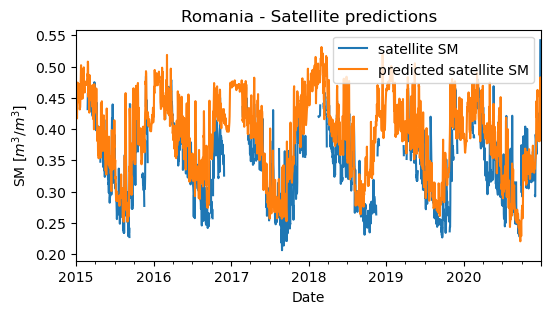

Figure 12 - Predicted vs observed Satellite Soil Moisture time series at the Romania site.


In [81]:
display(PREDICTION_FT.corr())
PREDICTION_FT.plot(title=f"{LOCATION} - Satellite predictions", ylabel='SM [$m^3/m^3$]', figsize=(6, 3))
plt.show()
print(f"Figure 12 - Predicted vs observed Satellite Soil Moisture time series at the {LOCATION} site.")

The value range of the predictions is not in line with the current location (there is a bias). This is probably because we used the global dataset for training. However, as we predicted SM for all time stamps, we can scale the predictions back to the available observations using a simple linear transformation. Afterwards, we only keep those values that were not originally observerd (Figure 13). This way we get estimates within the satellite observation gaps. 

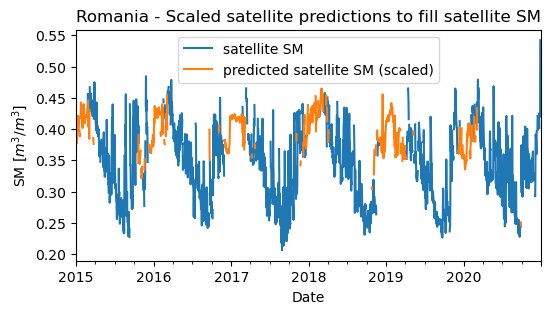

Figure 13 - Using the scaled predictions to fill gaps in the satellite time series


In [83]:
from pytesmo.scaling import linreg_params, linreg_stored_params

df = PREDICTION_FT[['predicted satellite SM', 'satellite SM']].dropna()
slope, inter = linreg_params(df['predicted satellite SM'].values, 
                             df['satellite SM'].values)

PREDICTION_FT["predicted satellite SM (scaled)"] = linreg_stored_params(
    PREDICTION_FT['predicted satellite SM'].values, slope, inter).copy()

idx = PREDICTION_FT[~np.isnan(PREDICTION_FT['satellite SM'].values)].index
PREDICTION_FT.loc[idx, "predicted satellite SM (scaled)"] = np.nan

PREDICTION_FT[['satellite SM', 'predicted satellite SM (scaled)']].plot(
    title=f"{LOCATION} - Scaled satellite predictions to fill satellite SM", ylabel='SM [$m^3/m^3$]', figsize=(6, 3))
plt.show()
print("Figure 13 - Using the scaled predictions to fill gaps in the satellite time series")


Finally, let's visually compare how different the predictions for the reanalysis data (from the first model) and the satellite data (from the fine-tuned model) actually are (Figure 14).

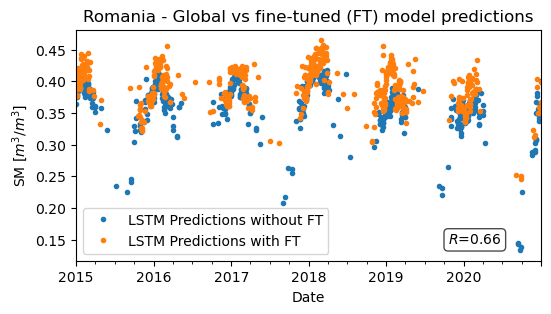

Figure 14 - Comparison of predicted fill values in gaps before/after fine tuning (FT)


In [97]:
gvf = pd.concat([PREDICTION['filled_lstm'], PREDICTION_FT['predicted satellite SM (scaled)']], axis=1,
                keys=['LSTM Predictions without FT', 'LSTM Predictions with FT'])
ax = gvf.plot(title=f"{LOCATION} - Global vs fine-tuned (FT) model predictions", ylabel='SM [$m^3/m^3$]', figsize=(6, 3),
             style='.')
plt.legend(loc="lower left")
ax.text(0.8, 0.06, f"$R$={gvf.corr().iloc[1,0]:.2f}", transform=ax.transAxes, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.show()
print("Figure 14 - Comparison of predicted fill values in gaps before/after fine tuning (FT)")

# Performance Evaluation and Validation

Lastly, we want to put the true performance of our models into numbers by validating them against in situ soil moisture measurements. The focus will be on the relative comparison of the different models, while the absolute deviation from in situ measurements is secondary here.

Because the in situ data is taken from a single location it naturally has a bias compared to the ERA5 reanalysis data which is an average over a larger area. In our case the bias is around 9 %-points. So, for better comparison we remove this bias from the in situ data before computing our performance metrics.

/var/folders/9c/7x6wf5fj0fbdvkxpnt4x2y7r0000gn/T/ipykernel_29421/2602473316.py:7: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(PREDICTION['in situ SM']+bias, label = 'Bias-corrected in situ SM')


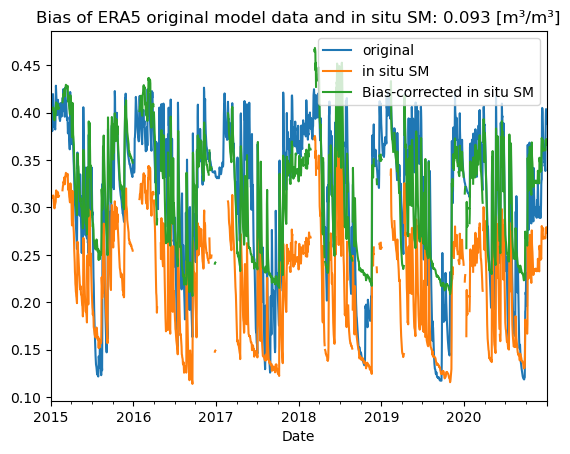

Figure 15 - Comparison of biases


In [99]:
# Correct for bias between ERA5 and in situ or not?
bias_correction = True
PREDICTION['in situ SM'] = DATA['in situ SM']
bias = PREDICTION['original'].mean()-PREDICTION['in situ SM'].mean()

PREDICTION[['original','in situ SM']].plot()
plt.plot(PREDICTION['in situ SM']+bias, label = 'Bias-corrected in situ SM')
plt.title(f'Bias of ERA5 original model data and in situ SM: {bias:.3f} [m³/m³]')
plt.legend()
plt.show()

if bias_correction:
    PREDICTION['in situ SM'] = DATA[[c for c in DATA.columns if c.startswith('in situ')]]['in situ SM']+bias
else:
    PREDICTION['in situ SM'] = DATA[[c for c in DATA.columns if c.startswith('in situ')]]['in situ SM']

print("Figure 15 - Comparison of biases")

For performance assessment we use 3 different metrics: 
- Correlation coefficient R²
- Mean absolute error (MAE)
- Mean squared error (MSE)

Moreover, we want to distinguish between small gaps (1 day) which are usually very easy to fill and larger gaps (> 1 day) where we expect the LSTM to show its strengths. For simplicity reasons only the filled_constant baseline model was depicted.

In terms of correlation with the in situ data (over all gaps), the baseline model (R² = 0.71) unfortunately cannot be outperformed by either of the two LSTMs (fine-tuned and not fine-tuned), though the fine-tuned model shows significantly better correlation (R² = 0.67). For large gaps, however, the constant baseline model is indeed slightly topped by the fine-tuned LSTM variant.

For the MAE and MSE, the picture changes: Now the NOT fine-tuned LSTM clearly shows better performance (MAE ~ 3-4 %-points) than the fine-tuned model (~ 7 %-points), though here the LSTMs can't beat the baseline model at all. 

To sum up, the fine-tuned LSTM variant seems to have a large bias while still showing better correlation with in situ data compared to the not fine-tuned, especially for larger gaps.

In [103]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Correlation coefficient R² (with in situ data)', 'MAE', 'MSE'],
        description='Select evaluation metric:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)

def performance_metrics(comp):
    PREDICTION['filled_lstm_ft'] = PREDICTION_FT['predicted satellite SM']
    # Distinguish between 1-day-gaps and longer gaps
    PREDICTION_gaps = count_gaps(np.isnan(PREDICTION['train'].values), PREDICTION['train'].index.values)
    PREDICTION_smallgaps = PREDICTION.loc[PREDICTION_gaps[PREDICTION_gaps['gapsize']==1].index.values]
    PREDICTION_largegaps = PREDICTION[~ PREDICTION.index.isin(PREDICTION_gaps[PREDICTION_gaps['gapsize']==1].index)]

    datasets = [PREDICTION, PREDICTION_smallgaps, PREDICTION_largegaps]
    dataset_labels = ['All gaps', 'Small gaps (1 day)', 'Large gaps (> 1 day)']
    

    #models = ['in situ SM', 'test'] + [c for c in PREDICTION.columns if c.startswith('filled')]
    models = ['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']
    #plot_df = pd.DataFrame(columns = dataset_labels, index = [['in situ SM', 'test'] + [c for c in PREDICTION.columns if c.startswith('filled')]])
    plot_df = pd.DataFrame(columns = dataset_labels, index = [['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']])
    
    
    if comp == 'Correlation coefficient R² (with in situ data)':
        for i, dataset in enumerate(datasets):
            #corr_df = dataset[['in situ SM', 'test'] + [c for c in dataset.columns if c.startswith('filled')]].corr()
            corr_df = dataset[['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']].corr()
            plot_df[dataset_labels[i]] = corr_df['in situ SM'].values   
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel(comp)

    
    elif comp == 'MAE':
    
        for i, dataset in enumerate(datasets):
            mae = [abs(dataset[model]-dataset['in situ SM']).mean() for model in models]
            #print('mae:', mae)
            plot_df[dataset_labels[i]] = mae
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel('Volumetric soil moisture [m³/m³]')
    
    elif comp == 'MSE':
        for i, dataset in enumerate(datasets):
            mse = [((dataset[model]-dataset['in situ SM'])**2).mean() for model in models]
            plot_df[dataset_labels[i]] = mse
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel('Volumetric soil moisture [m³/m³]')

    display(plot_df)
    
    plt.legend()
    plt.title(f'{comp} of different (baseline and ML) models')
    plt.grid()
    plt.tight_layout()
    plt.show()

    
    fig, ax = plt.subplots(2,len(datasets), figsize = (12,8))
    for i, dataset in enumerate(datasets):  
        ax[0,i].plot(np.arange(0.05,0.5,0.1), np.arange(0.05,0.5,0.1), c = 'black', linestyle = 'dashed')
        ax[0,i].set_title(dataset_labels[i])    
        #for j, model in enumerate(['in situ SM', 'test'] + [c for c in dataset.columns if c.startswith('filled')]):   
        for j, model in enumerate(['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']): 
            ax[0,i].scatter(dataset['in situ SM'], dataset[model], label = model, s = 5, alpha = 0.5) 
            ax[1,i].plot(dataset[model], label = model, linewidth = 1)            
    ax[0,0].legend()
    ax[0,0].set_ylabel('Modelled Volumetric soil moisture [m³/m³]')
    ax[0,0].set_xlabel('In situ Volumetric soil moisture [m³/m³]')

plt.show()
print("Figure 16 - Comparison against in situ data")

interactive(children=(Dropdown(description='Select evaluation metric:', layout=Layout(width='300px'), options=…

Figure 16 - Comparison against in situ data


Next, let's look at the seasonal differences in the performance. What we can see is that prediction correlation with in situ measurements is significantly lower during winter than during the other seasons. This makes sense, because measurement issues with frozen soil (and therefore gaps and missing information as mentioned in the beginning) usually occur during the winter months. What is more, the longest and therefore hardest-to-be-predicted SM gaps appear in the cold season.

Neither of the LSTM variations can seasonally outperform the baseline models with regard to correlation to in situ data. 
Only during the fall months and for MAE and MSE, the not fine-tuned LSTM beats the baseline models. The fine-tuned LSTM again performs mostly better in correlation, but much worse regarding MAE and MSE.

In [105]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Correlation coefficient R² (with in situ data)', 'MAE', 'MSE'],
        description='Select evaluation metric:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)

def performance_metrics(comp):

    # Distinguish between 4 different seasons
    PREDICTION_spring = PREDICTION[PREDICTION.index.month.isin([3,4,5])]
    PREDICTION_summer = PREDICTION[PREDICTION.index.month.isin([6,7,8])]
    PREDICTION_fall = PREDICTION[PREDICTION.index.month.isin([9,10,11])]
    PREDICTION_winter = PREDICTION[PREDICTION.index.month.isin([12,1,2])]

    datasets = [PREDICTION, PREDICTION_spring, PREDICTION_summer, PREDICTION_fall, PREDICTION_winter]
    dataset_labels = ['All seasons', 'Spring', 'Summer', 'Fall', 'Winter']


    
    #models = ['in situ SM', 'test'] + [c for c in PREDICTION.columns if c.startswith('filled')]
    models = ['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']
    #plot_df = pd.DataFrame(columns = dataset_labels, index = [['in situ SM', 'test'] + [c for c in PREDICTION.columns if c.startswith('filled')]])
    plot_df = pd.DataFrame(columns = dataset_labels, index = [['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']])
    
    
    if comp == 'Correlation coefficient R² (with in situ data)':
        for i, dataset in enumerate(datasets):
            #corr_df = dataset[['in situ SM', 'test'] + [c for c in dataset.columns if c.startswith('filled')]].corr()
            corr_df = dataset[['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']].corr()
            plot_df[dataset_labels[i]] = corr_df['in situ SM'].values   
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel(comp)
    
    elif comp == 'MAE':
    
        for i, dataset in enumerate(datasets):
            mae = [abs(dataset[model]-dataset['in situ SM']).mean() for model in models]
            #print('mae:', mae)
            plot_df[dataset_labels[i]] = mae
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel('Volumetric soil moisture [m³/m³]')
    
    elif comp == 'MSE':
        for i, dataset in enumerate(datasets):
            mse = [((dataset[model]-dataset['in situ SM'])**2).mean() for model in models]
            plot_df[dataset_labels[i]] = mse
        for model in plot_df.index.values:
            plt.scatter(plot_df.columns, plot_df.loc[model], label = model)
        plt.ylabel('Volumetric soil moisture [m³/m³]')

    display(plot_df)
    
    plt.legend()
    plt.title(f'{comp} of different (baseline and ML) models')
    plt.grid()
    plt.tight_layout()
    plt.show()

    
    fig, ax = plt.subplots(2,len(datasets), figsize = (12,8))
    for i, dataset in enumerate(datasets):  
        ax[0,i].plot(np.arange(0.05,0.5,0.1), np.arange(0.05,0.5,0.1), c = 'black', linestyle = 'dashed')
        ax[0,i].set_title(dataset_labels[i])   
        #for j, model in enumerate(['in situ SM', 'test'] + [c for c in dataset.columns if c.startswith('filled')]):   
        for j, model in enumerate(['in situ SM', 'test', 'filled_const', 'filled_lstm', 'filled_lstm_ft']): 
            ax[0,i].scatter(dataset['in situ SM'], dataset[model], label = model, s = 5, alpha = 0.5) 
            ax[1,i].plot(dataset[model], label = model, linewidth = 1)           
    ax[0,0].legend()
    ax[0,0].set_ylabel('Modelled Volumetric soil moisture [m³/m³]')
    ax[0,0].set_xlabel('True Volumetric soil moisture [m³/m³]')

plt.show()
print("Figure 17 - Comparison of seasonal differences")

interactive(children=(Dropdown(description='Select evaluation metric:', layout=Layout(width='300px'), options=…

Figure 17 - Comparison of seasonal differences


# Discussion and conclusions
- Understanding gap characteristics is key to implementing a good model to fill data gaps. Gaps are **systematically** missing, not randomly!
- The current LSTM can create reasonable predictions. However, currently the baseline models still perform better.
- Our LSTM setup could probably be simplified (bidirectional model might not be necessary?).
- Using Reanalysis data for training is a compromise, as there are some differences compared to the satellite data. In situ (temperature, rainfall, etc.) measurements could be used. There are also satellite products for rainfall and temperature.
- We did not use soil moisture as a feature in the current model. This means that our predictions are based on the covariates only at the moment. Ideally, the model should use the available SM data as well (high temporal autocorrelation makes SM an important feature). However, overfitting could be a problem. When SM is used as a feature, the Loss function could be updated to give a higher weight to predictions made within observation gaps.
- As soil moisture is not a feature in the current model, our predictions for reanalysis and satellite SM are overall similar. If the model would also use (satellite) SM, it could improve the predictions.
- Fine-tuning the model seems like a good idea, but the current setup does not add much skill (in some regard it makes the predictions worse).
- The initial plan was to test whether predicting SM anomalies provides any benefit (compred to predicting the absolute values). This should still be done, as it's very easy with the current setup (but it requires a lengthy re-training).

**We see potential in the current setup and will work on improving it in the future.**